In [197]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import plotly.offline as py
py.init_notebook_mode(connected=True)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score,precision_recall_curve)
import copy

In [198]:
#Data defination
attrition = pd.read_csv('3_sheets.csv')
attrition.head()

def intify(s):
    u = np.unique(s)
    i = np.arange(len(u))+1
    return s.map(dict(zip(u, i)))

In [199]:
num_timestamps = 3
a = attrition.columns.values
#c = attrition.dtypes
for col_name in a:
    if not np.issubdtype(attrition[col_name].dtype,np.number):
        attrition[[col_name]] = intify(attrition.get(col_name))

#pd.DataFrame(data=attrition, columns = [a[0]]).Age.dtype
#attrition.Department = intify(attrition.Department)
#attrition.Department
#not numpy.issubdtype(attrition['Age'].dtype,numpy.number)
attrition.Attrition = attrition.Attrition - 1
attrition.to_csv('new_converted_data.csv')
attritions = np.array_split(attrition,num_timestamps)
for i in range(num_timestamps-1,-1,-1):
    attritions[i].index = range(0,1470)

In [200]:
df = copy.deepcopy(attritions[0])
del df['Attrition']
del df['EmployeeNumber']
df['attrition'] = attritions[0].Attrition

In [201]:
df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75
df.head()
# Create two new dataframes, one with the training rows, one with the test rows
train, test = df[df['is_train']==True], df[df['is_train']==False]

# Show the number of observations for the test and training dataframes
print('Number of observations in the training data:', len(train))
print('Number of observations in the test data:',len(test))

Number of observations in the training data: 1116
Number of observations in the test data: 354


In [202]:
features = df.columns[:33]

In [203]:
x_train = train
y_train = train['attrition']
train.head()

# Defining test
x_test = test
y_test = test['attrition']

In [204]:
# Create a random forest Classifier
clf = RandomForestClassifier(n_estimators=25, n_jobs=2, random_state=0)

# Train the Classifier to take the training features and learn how they relate to the training y (attrition_num)
clf.fit(train[features], y_train)

# Apply the Classifier we trained to the test data
clf.predict(test[features])

# View the predicted probabilities of the first 10 observations
clf.predict_proba(test[features])[0:10]
preds = clf.predict(test[features])

In [205]:
# Create confusion matrix, WHICH REALLY IS CONFUSING AT FIRST
pd.crosstab(test['attrition'], preds, rownames=['Actual Attrition'], colnames=['Predicted Attrition'])

# View a list of the features and their importance scores
list(zip(train[features], clf.feature_importances_))

# The accuracy_score function computes the accuracy, either the fraction (default) or the count (normalize=False) of
#correct predictions.
score = accuracy_score(y_test, preds)
score_count = accuracy_score(y_test, preds, normalize=False)
print(score)
print(score_count)

0.8559322033898306
303


In [206]:
f1_score(y_test, preds, average='binary')

0.23880597014925373

In [207]:
precision_recall_curve(y_test,preds)

(array([0.15536723, 0.66666667, 1.        ]),
 array([1.        , 0.14545455, 0.        ]),
 array([0, 1]))

In [211]:
precision_score(y_test,preds)
#y_test

0.6666666666666666

In [212]:
recall_score(y_test,preds)

0.14545454545454545

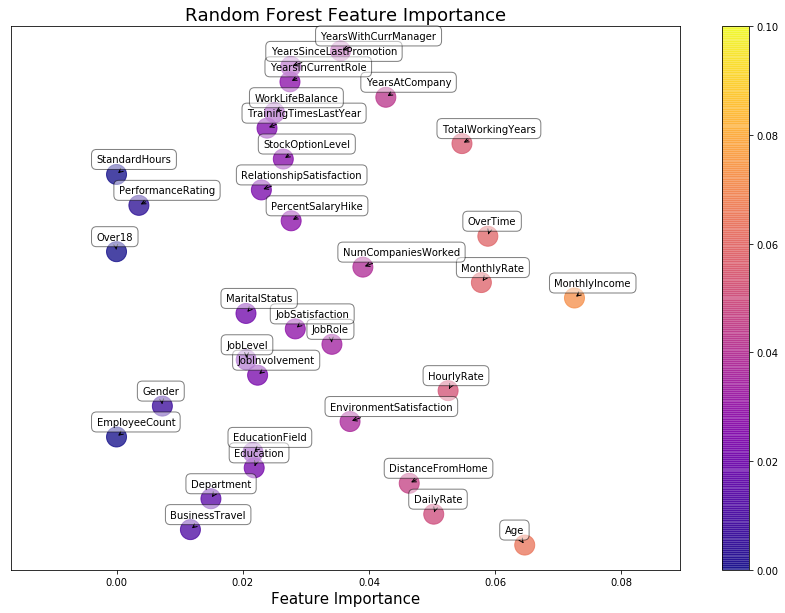

In [209]:
# Scatter plot
y = features
x = clf.feature_importances_
plt.figure(figsize=(15, 10))
plt.scatter(x, y, c=x, vmin=0, vmax=0.10, s=400, alpha = 0.75, cmap='plasma')
plt.colorbar()
#plt.ylabel('Attributes')
plt.xlabel('Feature Importance', fontsize=15)
plt.yticks([])
#plt.xticks(rotation=90)
plt.title('Random Forest Feature Importance', fontsize=18)
labels = features
for label, x, y in zip(labels, x, y):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='left', va='top',
        bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
plt.show() 

In [210]:
for i in range(num_timestamps-1,-1,-1):
    divide = attritions[i].div(attritions[0],axis=1)
    a = (divide.replace([-np.inf,np.inf,np.nan],0)+attritions[i].mul(((divide==np.inf)|(divide==-np.inf) | np.isnan(divide))*1))
    a.EmployeeNumber =  attritions[i].EmployeeNumber
    a.Attrition = attritions[i].Attrition
    attritions[i] = a
    attritions[i].to_csv('normalized_'+ str(i)+'.csv')
